<a href="https://colab.research.google.com/github/ydaigo/The-4th-Tellus-Satellite-Challenge/blob/main/HAIM%E5%8B%89%E5%BC%B7%E4%BC%9A12%E6%9C%8819%E6%97%A5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#HAIM勉強会12月19日
#海岸線抽出コンペ奮闘記

#自己紹介

- twitter abcd161  
- 住んでいる所　富山  
- 目標　kaggleでExpertになること

- signateでの実績
  - [国立国会図書館の画像データレイアウト認識](https://signate.jp/competitions/218) 14/101
  - [The 4th Tellus Satellite Challenge：海岸線の抽出](https://signate.jp/competitions/284) 22/125　今回のLTでプレゼン

![](https://i.imgur.com/UW28ZLP.png)

# 海岸線の抽出コンペ概要

- 内容
  - 海岸の衛星データから海と陸の境界である海岸線を抽出精度を競う。
  ![](https://i.imgur.com/7dmXLD9.png)
- 社会的意義
  - 海岸の浸食されることで動植物への影響や高潮や津波を防ぐ能力が弱くなることが問題となっている。
  - 衛星から海岸を監視することで海岸の浸食をいち早く察知する取り組みがある。
  - 衛星の画像から海岸領域を判読するのに高度なスキルが必要である。  
↓  
高い精度で海岸線を抽出するアルゴリズムが必要！

- 結果
  - サブミットとスコアの推移

![](https://i.imgur.com/9GtnhQF.png)


# コンペの流れ

![](https://i.imgur.com/nofA3zy.png)


# 奮闘記

本コンペでの自分の取り組みを説明

- 第1話: 評価指標を見てみる

- 第2話: サンプル用の提出データをとりあえず提出する

- 第3話 データを見る

- 第4話: kaggleで似たコンペがないかを探す

- 第5話: Unetとは?

- 第6話: 入力画像を大きくする→成功

- 第7話: モデルを深くする→失敗

# 第1話　評価指標を見る
- 実際の海岸線に垂直にひかれた評価選を用いて、予測した海岸線と実際の海岸線との誤差をスコアとして算出する。

- 評価線一つあたりの誤差が評価指標となる。

- 評価線の長さは165ピクセルであるため、165が最低スコアである

- 誤差が小さいほど検出精度が高いことになる。


<img src="https://static.signate.jp/competitions/284/RsCDYrykZ4dblRI8WQQltbAgyWRFs6nu3laR3llE.png" width="60%">


#第2話サンプル用の提出データをとりあえず提出する

- サンプル用の提出データは左上から右下に海岸線があるとすべて予測されている

![](https://i.imgur.com/PPGzvFa.png)


![](https://i.imgur.com/iweXCHR.png)


# 第3話 データを見る
- 訓練用の海岸線の画像が20枚とそれらに対応する海岸線の位置を表したjsonファイルとテスト用の海岸の画像が30枚与えられる。
  - 時間帯の違う同じ場所の画像がありデータが欠損している

  ![](https://i.imgur.com/9VDH7Dx.png)
  - 画像サイズが大きい
  
  ![](https://i.imgur.com/DoOsqSh.png)








# 第4話　kaggleで似たコンペがないかを探す

- [TGS Salt Identification Challenge](https://www.kaggle.com/c/tgs-salt-identification-challenge)という地質画像から塩領域を特定するコンテストが見つかった
  - コンペの内容はする塩領域とそうでない領域をピクセル単位で分類
  - 緑が塩がない領域またはすべてが塩の領域、赤が塩がある領域

![](https://i.imgur.com/KzPpwoz.png)
[出典](https://arxiv.org/pdf/1904.04445.pdf)

- このコンペの[Notebooks](https://www.kaggle.com/jesperdramsch/intro-to-seismic-salt-and-how-to-geophysics)を参考にコードを書くことにした
  - 塩領域の分類をUnetというアルゴリズムを用いて実現している
  - kerasを用いてUnetを実装している

# 第5話 Unetとは?

- セマンティックセグメンテーションのアルゴリズムの一つ
- 
- セマンティックセグメンテーションとは画像に写っている物体をピクセルレベルで識別する技術  
セマンティックセグメンテーションの例  
![](https://raw.githubusercontent.com/open-mmlab/mmdetection/master/resources/coco_test_12510.jpg)

- Unetのアーキテクチャー

![](https://www.acceluniverse.com/blog/developers/u_net_arc2.png)

- 特徴
  - 学習が速い
  - 少ないデータで学習ができる

#第3話 境界線を予測するモデルを作る→失敗

- Unetのモデルを入力画像を海岸の画像、出力画像を海岸線の画像として学習させた  
↓   
##失敗

![](https://i.imgur.com/gyZwaQ4.png)


- 理由
  - 正解ラベルの数が少なすぎて、適切にモデルをとレーニングができなかったため。

# 第5話セマンティックセグメンテーション用にラベルを付けなおして再学習！

- 手動でマスク画像を作成し直す
- 画像サイズは128*128

![](https://i.imgur.com/ZmIyFLQ.png)

![Uploading file..._gptip3pzt]()


#第6話データを拡張してみる
- 欠損データに対応するためにデータの拡張により疑似的にデータが欠損した部分を作成する。

![](https://i.imgur.com/KH7KPjz.png)

![](https://i.imgur.com/55Va3DS.png)



# 第7話 入力サイズを大きくする
- 入力画像サイズを128＊128から512＊512とした

![](https://i.imgur.com/152bh0w.png)


#最終話　結果
###シェイクアップ!!
- 暫定スコア 30  
↓
- 最終スコア 18  

#結果22位となった！

# ハンズオン


In [1]:
#@title ライブラリのインポート
!git clone https://github.com/ydaigo/The-4th-Tellus-Satellite-Challenge.git
!pip uninstall tensorflow -y
!pip install tensorflow-gpu==1.15
!pip uninstall keras -y
!pip install keras==2.2.4
import os
import sys
import random
import warnings
import json

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import cv2
import tifffile
from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

import tensorflow as tf

from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

Cloning into 'The-4th-Tellus-Satellite-Challenge'...
remote: Enumerating objects: 28, done.
remote: Counting objects: 100% (28/28), done.
remote: Compressing objects: 100% (25/25), done.
remote: Total 28 (delta 8), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (28/28), done.
Uninstalling tensorflow-2.4.0:
  Successfully uninstalled tensorflow-2.4.0
     |████████████████████████████████| 411.5MB 44kB/s 
     |████████████████████████████████| 3.8MB 51.1MB/s 
     |████████████████████████████████| 51kB 9.1MB/s 
     |████████████████████████████████| 512kB 50.7MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7540 sha256=b1cc511dbb05f5754b6714b474dd38afedcf7132018d1482ef6552f4bf2ee07f
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow-probability 0.11.0 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
  Found existing insta

Using TensorFlow backend.


NameError: ignored

In [2]:
#@title 前処理
im_width = 512
im_height = 512
im_chan = 1
train_ids = [1,2]
X_train = np.zeros((len(train_ids), im_height, im_width, im_chan), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), im_height, im_width, 1), dtype=np.bool)
print('Getting and resizing train images and masks ... ')
sys.stdout.flush()

sizes_train = []
for n,id_ in enumerate(train_ids):
    img = load_img(f'/content/The-4th-Tellus-Satellite-Challenge/data/train_gray_{id_:02d}.png')
    x = img_to_array(img)[:,:,1]
    sizes_train.append([x.shape[0], x.shape[1]])
    x = resize(x, (im_height, im_width, 1), mode='constant', preserve_range=True)
    X_train[n] = x
    mask = img_to_array(load_img(f'/content/The-4th-Tellus-Satellite-Challenge/data/train_mask_{id_:02d}.png'))[:,:,1]
    mask = np.where(mask==255,0,255)
    Y_train[n] = resize(mask, (im_width, im_height, 1), mode='constant', preserve_range=True)

Getting and resizing train images and masks ... 


In [5]:
#@title データの拡張
data_gen_args  =dict(featurewise_center=False, 
                             samplewise_center=False, 
                             featurewise_std_normalization=False,
                             samplewise_std_normalization=False, 
                             zca_whitening=False, 
                             zca_epsilon=1e-06, 
                             rotation_range=90, 
                             width_shift_range=0.1, 
                             height_shift_range=0.1,
                             brightness_range=None,
                             shear_range=90, zoom_range=0.0,
                             channel_shift_range=0.0,
                             fill_mode='constant', cval=0.0,
                             horizontal_flip=True, 
                             vertical_flip=True, 
                             rescale=None, 
                             preprocessing_function=None, 
                             data_format=None,
                             validation_split=0.0)
image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen = ImageDataGenerator(**data_gen_args)
seed = 1
image_datagen.fit(X_train, augment=True, seed=seed)
mask_datagen.fit(Y_train, augment=True, seed=seed)
image_generator = image_datagen.flow(X_train[:17], y=None, batch_size=32, shuffle=False, seed=0, save_to_dir=None, save_prefix='', save_format='png', subset=None)
mask_generator = mask_datagen.flow(Y_train[:17], y=None, batch_size=32, shuffle=False, seed=0, save_to_dir=None, save_prefix='', save_format='png', subset=None)
train_generator = zip(image_generator, mask_generator)

In [3]:
#@title モデル
# Define IoU metric
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)
# Build U-Net model
inputs = Input((im_height, im_width, im_chan))
s = Lambda(lambda x: x / 255) (inputs)

c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (s)
c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (p1)
c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (p2)
c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (p3)
c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(128, (3, 3), activation='relu', padding='same') (p4)
c5 = Conv2D(128, (3, 3), activation='relu', padding='same') (c5)

u6 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (u6)
c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (c6)

u7 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (u7)
c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (c7)

u8 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (u8)
c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (c8)

u9 = Conv2DTranspose(8, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (u9)
c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[mean_iou])
model.summary()







Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
Use `tf.cast` instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.






__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 512, 512, 1)  0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 512, 512, 1)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 512, 512, 8)  80          lambda_1[0][0]                   
_________________________________________________________________________

In [6]:
#title 学習
import keras
model = load_model('/content/The-4th-Tellus-Satellite-Challenge/34.h5', custom_objects={'mean_iou': mean_iou})
class nvidia(keras.callbacks.Callback):
    def on_batch_end(self, batch, logs={}):
        !nvidia-smi
earlystopper = EarlyStopping(patience=500, verbose=1)
nvidiaCallback = nvidia()
checkpointer = ModelCheckpoint('/content/model-tgs-salt-1.h5', verbose=1, save_best_only=True,monitor='val_mean_iou', mode='max')
results = model.fit_generator(train_generator, validation_data=(X_train,Y_train), steps_per_epoch=300, epochs=300,
                    callbacks=[earlystopper, checkpointer],shuffle=False)

Epoch 1/300
193/300 [==================>...........] - ETA: 14s - loss: 0.6144 - mean_iou: 0.3252

KeyboardInterrupt: ignored

In [13]:
#@title 予測
model = load_model('/content/The-4th-Tellus-Satellite-Challenge/34.h5', custom_objects={'mean_iou': mean_iou})
preds_train = model.predict(X_train[:int(X_train.shape[0])], verbose=1)

# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)

2/2 [==============================] - 1s 281ms/step


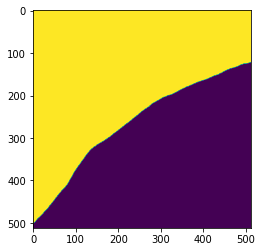

In [14]:
# 予測結果の確認
plt.imshow(np.squeeze(preds_train_t[0]))
plt.show()